## Load data

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_airlines = "./datasets/airlines.csv"
path_airport = "./datasets/airports.csv"
path_flights = "./datasets/flights.csv"

df_airlines = pd.read_csv(path_airlines, low_memory=False)
df_airport = pd.read_csv(path_airport, low_memory=False)
raw_flights = pd.read_csv(path_flights, low_memory=False)
df_flights = raw_flights.copy()
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

The flights data are collected in 2015, we visualize the flight frequency gouuped according to each month, we find that they are evenly distributed. 

<Axes: xlabel='YEAR,MONTH'>

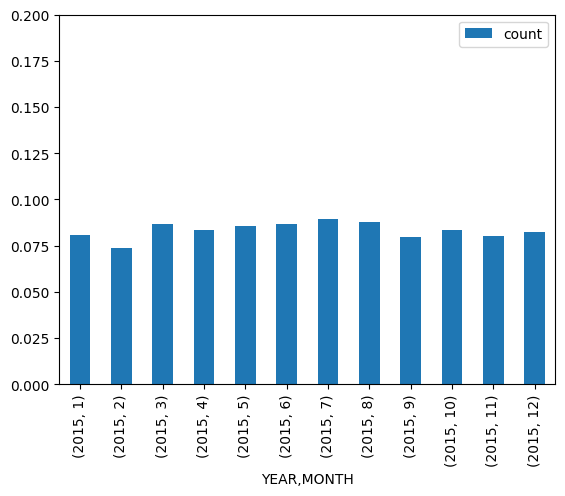

In [3]:
(df_flights.groupby([df_flights['YEAR'], df_flights['MONTH']]).agg({'count'})['FLIGHT_NUMBER']/df_flights['FLIGHT_NUMBER'].count()).plot(ylim=(0,0.2),kind="bar")


In [4]:
# transform df_airlines to dict
dict_airlines = df_airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()

# only keep flight starting and ending from airport in the airports.csv
df_flights = df_flights[(df_flights['ORIGIN_AIRPORT'].isin(df_airport['IATA_CODE'])) & (df_flights['DESTINATION_AIRPORT'].isin(df_airport['IATA_CODE']))]

We change the format of "HHMM" string to minutes. 

In [5]:
def mintues(formatted_time):
    if formatted_time == 2400:
        formatted_time = 0
    formatted_time = "{0:04d}".format(int(formatted_time))
    return int(formatted_time[0:2])*60+int(formatted_time[2:4])

df_flights['SCHEDULED_DEPARTURE'] = df_flights['SCHEDULED_DEPARTURE'].apply(mintues)
df_flights['SCHEDULED_ARRIVAL'] = df_flights['SCHEDULED_ARRIVAL'].apply(mintues)


In the simple model, we only consider the following attributes. 

In [6]:
df_flights = df_flights[['AIRLINE', 'MONTH', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL','ARRIVAL_DELAY', 'SCHEDULED_TIME', 'ELAPSED_TIME']]

In [7]:
missing_df = df_flights.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df_flights.shape[0]-missing_df['missing values'])/df_flights.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,101784,98.091400
1,ELAPSED_TIME,101784,98.091400
2,DEPARTURE_DELAY,83814,98.428364
3,SCHEDULED_TIME,6,99.999887
4,AIRLINE,0,100.000000
5,MONTH,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


Since most of the rows are complete, we directly drop incomplete rows.

In [8]:
df_flights.dropna(inplace = True)

We plot the histogram for each airplane company. The x-axis is the DEPARTURE_DELAY in minutes, and the y-axis is the frequency. The fitting model is $a$-exp distribution. Smaller $a$ denotes the a large proportion of long delays. From the variance of $a4 in the estimation, we can conclude the exponential distribution model is plausible. 

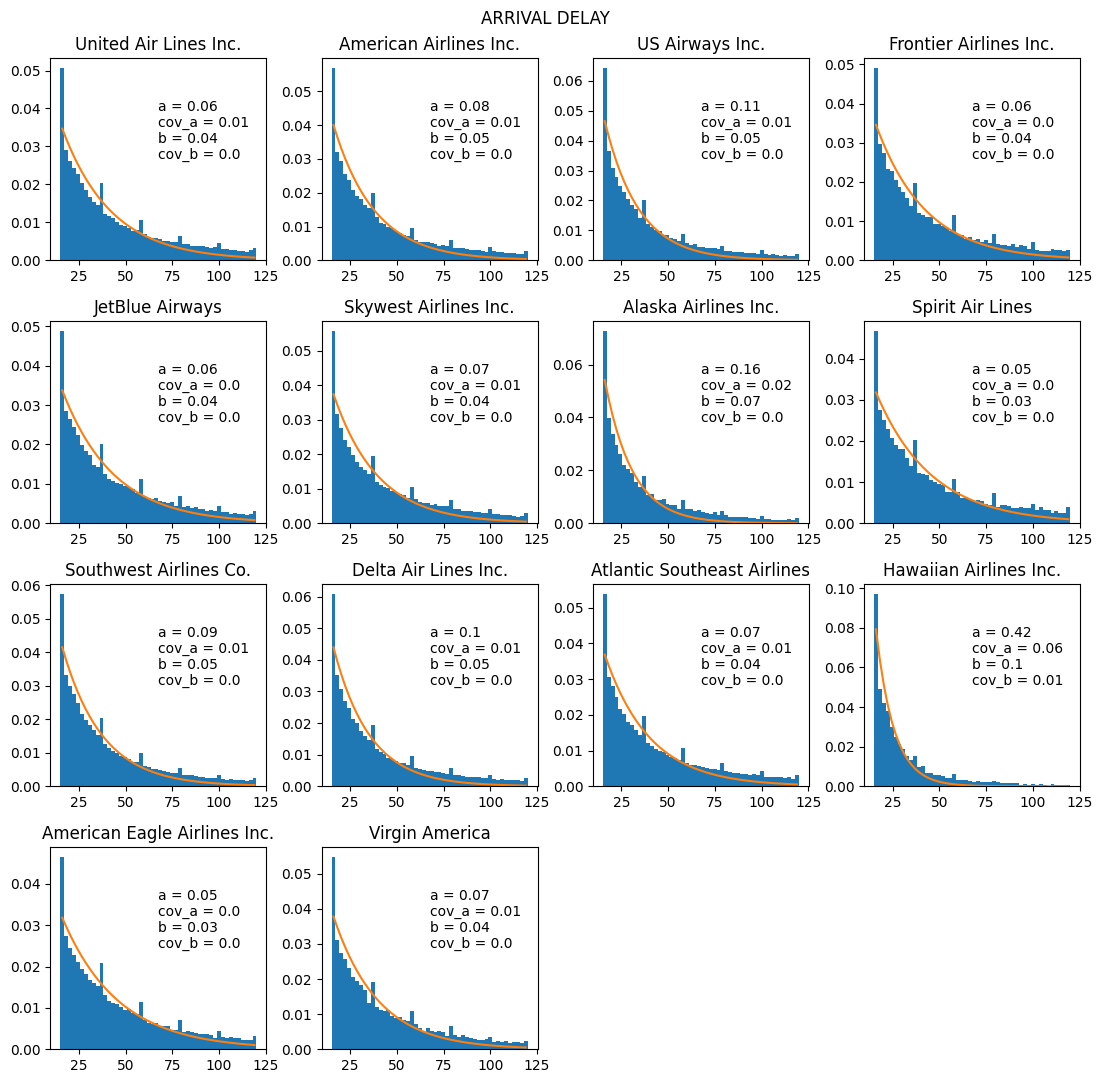

In [9]:
from scipy.optimize import curve_fit
dist_exp = lambda x, a, b: a*np.exp(-b*x)

fig = plt.figure(1, figsize=(11,11))
i = 0
for x in df_airlines['IATA_CODE']:
    i += 1
    ax = fig.add_subplot(4,4,i)
    counts, bins, patches = plt.hist(x = df_flights[df_flights['AIRLINE']==x]['ARRIVAL_DELAY'],range = (15,120), density=True, bins=50) # 15 min to 3 hours
    plt.title(dict_airlines[x], fontsize = 12)
    x_bin = 0.5 * (bins[1:] + bins[:-1])

    # fit the exp distribubtion
    popt, pcov = curve_fit(dist_exp, x_bin, counts, p0 = (1, 1e-6))
    perr = np.sqrt(np.diag(pcov))
    plt.plot(x_bin, dist_exp(x_bin, *popt))
    ax.text(0.5, 0.5, 'a = {}\ncov_a = {}\nb = {}\ncov_b = {}'.format(round(popt[0],2), round(perr[0],2), round(popt[1],2), round(perr[1],2)), transform=ax.transAxes)
plt.suptitle("ARRIVAL DELAY")
plt.tight_layout()


To avoid extreme values, we discard those which delays over two hours.

In [10]:
df_flights.drop(df_flights[df_flights["ARRIVAL_DELAY"]>120].index, inplace=True)

In [50]:
def get_delays(df, airline=None):
    if airline is not None:
        df1 = df[df['AIRLINE'] == airline]
        df2 = df1.groupby(['MONTH', 'SCHEDULED_TIME', 'DESTINATION_AIRPORT'])['ARRIVAL_DELAY'].apply(lambda x: {'MEAN': x.mean()}).unstack().reset_index()
        df2['AIRLINE'] = airline
    else:
        df1 = df.copy()
        df2 = df1.groupby(['AIRLINE', 'MONTH', 'SCHEDULED_TIME', 'DESTINATION_AIRPORT'])['ARRIVAL_DELAY'].apply(lambda x: {'MEAN': x.mean()}).unstack().reset_index()
    return df2

df_flights_delays = get_delays(df_flights)

In [51]:
import sklearn.model_selection
df_flights_delays_train, df_flights_delays_test = sklearn.model_selection.train_test_split(df_flights_delays, test_size=0.3)

We build the baseline model by linear regression based on the one-hot encoded 'AIRLINE', 'MONTH' and 'ORIGIN_AIRPORT', and the 'SCHEDULED_DEPARTURE' time in minutes. 

In [52]:
from sklearn.preprocessing import OneHotEncoder

onehot_airline_encoder = OneHotEncoder(sparse_output=False).fit(df_flights['AIRLINE'].to_frame())
onehot_airport_encoder = OneHotEncoder(sparse_output=False).fit(df_flights['DESTINATION_AIRPORT'].to_frame())
onehot_month_encoder = OneHotEncoder(sparse_output=False).fit(df_flights['MONTH'].to_frame())

In [53]:
def generate_datasets(df):
    onehot_airline_encoded = onehot_airline_encoder.transform(df['AIRLINE'].to_frame())
    onehot_dest_airport_encoded = onehot_airport_encoder.transform(df['DESTINATION_AIRPORT'].to_frame())
    onehot_month_encoded = onehot_month_encoder.transform(df['MONTH'].to_frame())

    scheduled_time = np.array([df['SCHEDULED_TIME']])
    scheduled_time = scheduled_time.reshape(-1,1)
    X = np.hstack((onehot_airline_encoded, onehot_dest_airport_encoded, onehot_month_encoded, scheduled_time))
    Y = np.array(df['MEAN'])
    Y = Y.reshape(-1, 1)
    return X, Y


The MSE and error on the test set is

In [54]:
from sklearn import linear_model
X_train, Y_train = generate_datasets(df_flights_delays_train)
X_test, Y_test = generate_datasets(df_flights_delays_test)

model = linear_model.LinearRegression().fit(X_train, Y_train)

def baseline_test(model, X_test, Y_test):
    pred = model.predict(X_test)
    print("MSE =", sklearn.metrics.mean_squared_error(pred, Y_test))
    count = 0
    for i, val in enumerate(Y_test):
        if abs(val-pred[i]) > 15:
            count += 1
    acc = count / len(pred)
    print('Error {:.2f}%'.format(acc * 100))
    return acc


acc = baseline_test(model, X_test, Y_test)

MSE = 160.60359218863906
Error 15.75%


We analyze the performance of the baseline by separating the airline in different cases. 

In [55]:
errs = dict()
for airline in dict_airlines:
    X_test_1, Y_test_1 = generate_datasets(df_flights_delays_test[df_flights_delays_test['AIRLINE']==airline])
    acc = baseline_test(model, X_test_1, Y_test_1)
    errs[airline] = acc


MSE = 221.041990309951
Error 22.35%
MSE = 115.55708537641623
Error 11.97%
MSE = 133.4754960977981
Error 13.27%
MSE = 246.1826563049399
Error 20.76%
MSE = 163.4607429777541
Error 17.85%
MSE = 186.5095972187727
Error 17.08%
MSE = 107.00805734727204
Error 12.42%
MSE = 174.82457954453452
Error 21.60%
MSE = 97.04153143058814
Error 11.14%
MSE = 157.36571586600712
Error 13.30%
MSE = 170.9903505848208
Error 16.47%
MSE = 53.123373415787604
Error 3.83%
MSE = 141.1292012216074
Error 15.83%
MSE = 129.85503298386016
Error 14.57%


In [56]:
print(errs)

{'UA': 0.22354497354497355, 'AA': 0.1196724051479191, 'US': 0.13268744734625104, 'F9': 0.2076095947063689, 'B6': 0.17849141150112025, 'OO': 0.17082509881422925, 'AS': 0.12419274714356682, 'NK': 0.21603711066931744, 'WN': 0.11141022986125491, 'DL': 0.13298429319371727, 'EV': 0.16467622080679406, 'HA': 0.038314176245210725, 'MQ': 0.15834829443447038, 'VX': 0.145679012345679}


We see that the linear model's performance on different airlines varies drastically.